In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import precision_score, recall_score, log_loss, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
X_df = pd.read_csv("Training_set_values.csv")
y_df = pd.read_csv("Training_set_labels.csv")

X_submit = pd.read_csv("Test_set_values.csv")

In [3]:
train_df = pd.merge(y_df, X_df, how='inner', on='id')

In [4]:
train_df['status'] = train_df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})

In [5]:
train_df

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,2
59397,37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,2
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2


In [6]:
train_df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [7]:
train_df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [8]:
train_df = train_df.drop(['scheme_name', 
                         'num_private', 
                         'lga', 
                         'ward', 
                         'recorded_by', 
                         'extraction_type',
                         'extraction_type_class',
                         'management_group',
                         'payment',
                         'water_quality',
                         'quantity',
                         'source',
                         'source_class',
                         'waterpoint_type',
                         'date_recorded'], axis=1)
                        

In [9]:
train_df = train_df.set_index('id')

In [10]:
num_dict = {}
dfp = train_df.copy().drop(['status_group', 'status'], axis =1)

for x in dfp.columns:
    if dfp[x].dtypes == 'object':
        num_dict[x] = len(dfp[x].value_counts())
num_dict
    

{'funder': 1897,
 'installer': 2145,
 'wpt_name': 37400,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'public_meeting': 2,
 'scheme_management': 12,
 'permit': 2,
 'extraction_type_group': 13,
 'management': 12,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_type': 7,
 'waterpoint_type_group': 6}

In [11]:
train_df = train_df.drop(['funder','installer','wpt_name','subvillage'], axis=1)

In [12]:
train_df.isna().sum()

status_group                0
amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type_group       0
management                  0
payment_type                0
quality_group               0
quantity_group              0
source_type                 0
waterpoint_type_group       0
status                      0
dtype: int64

In [13]:
train_df = train_df.dropna()

In [14]:
train_df.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
status                   0
dtype: int64

In [15]:
train_df['public_meeting'] = train_df['public_meeting'].astype(int)
train_df['permit'] = train_df['permit'].astype(int)

In [16]:
X = train_df.drop(['status_group', 'status'], axis=1)
y = train_df['status']

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49841 entries, 69572 to 26348
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             49841 non-null  float64
 1   gps_height             49841 non-null  int64  
 2   longitude              49841 non-null  float64
 3   latitude               49841 non-null  float64
 4   basin                  49841 non-null  object 
 5   region                 49841 non-null  object 
 6   region_code            49841 non-null  int64  
 7   district_code          49841 non-null  int64  
 8   population             49841 non-null  int64  
 9   public_meeting         49841 non-null  int32  
 10  scheme_management      49841 non-null  object 
 11  permit                 49841 non-null  int32  
 12  construction_year      49841 non-null  int64  
 13  extraction_type_group  49841 non-null  object 
 14  management             49841 non-null  object 
 15

In [18]:
X_ohe = X.select_dtypes('object')

ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
fitohe = ohe.fit_transform(X_ohe)
temp_df = pd.DataFrame(fitohe, columns=ohe.get_feature_names(), index=X.index)


X_ss = X.select_dtypes(exclude='object').drop(['public_meeting', 'permit'], axis=1)

ss = StandardScaler()
fitss = ss.fit_transform(X_ss)
temp_df1 = pd.DataFrame(fitss, index=X.index)

temp_df2 = X[['public_meeting', 'permit']]

X_clean = pd.concat([temp_df1, temp_df2, temp_df], axis=1)

In [19]:
X_clean

,0,1,2,3,4,5,6,7,public_meeting,permit,...,x8_other,x8_rainwater harvesting,x8_river/lake,x8_shallow well,x8_spring,x9_communal standpipe,x9_dam,x9_hand pump,x9_improved spring,x9_other
id,,,,,,,,,,,,,,,,,,,,,
69572,2.021817,1.015156,0.113284,-1.431726,-0.218674,-0.087382,-0.135328,0.732321,1,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
34310,-0.117138,0.007457,0.516195,0.672561,0.364162,-0.188374,0.166665,0.742837,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67743,-0.126088,-0.598021,0.679989,-1.884655,4.385730,5.770186,-0.244560,0.718650,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9944,-0.118928,-0.974477,0.789660,0.343316,-0.626659,0.215596,-0.366643,0.742837,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19816,-0.126088,-0.974477,-0.138387,0.691726,0.131028,-0.289367,-0.368784,-1.369834,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,-0.122508,0.757506,0.469738,0.870431,-0.684942,-0.087382,-0.101060,0.732321,1,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
27263,1.556437,0.760369,0.163101,-1.157770,-0.218674,-0.188374,-0.248844,0.729166,1,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
37057,-0.126088,-0.974477,-0.033821,-1.046124,-0.160390,0.114603,-0.368784,-1.369834,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


0.45251901045324133


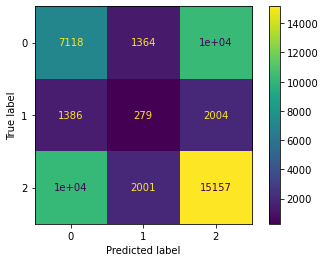

In [27]:
dummy = DummyClassifier(random_state=16)
dummy.fit(X_clean, y)
print(dummy.score(X_clean, y))

plot_confusion_matrix(dummy, X_clean, y);


In [20]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

In [ ]:
#have to change fit variables since we will be TTS'ing


from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_clean, y)

#scores on folds
scores = cross_val_score(estimator=rfc, X=X_clean, y=y, cv=5)

#scores on on test
score = random_forest.score(X_test, y_test)

#grid search on random forest
grid = {
    'criterion' : ['entropy', 'gini'],
    'max_depth': [5,10,15,20, None],
    'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3,0.4, 0.5],
    'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5],
    'bootstrap' : [False, True] 
}
gs = GridSearchCV(estimator=dt , param_grid=grid, cv=5)
gs.fit(X_train, y_train)

print(f'Best parameters are {gs.best_params_}')
print(f'Best score {gs.best_score_}')
print(f'Best estimator score {gs.best_estimator_.score(X_test, y_test)}')



#Can use attributes in random forest to display multiple decision trees
feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, random_forest.feature_importances_)
}
feat_import
#from the values you can then hand pick which features to pick from and change dataset